In [ ]:
!pip3 install seaborn 

In [227]:
def batch_training(TrainSetPath, TestSetPath, BatchSize, epochs):
    import pandas as pd
    import torch
    import torch.nn as nn
    import numpy as np
    import matplotlib.pyplot as plt 

    # takes in a module and applies the specified weight initialization
    def weights_init_normal(m):
        '''Takes in a module and initializes all linear layers 
        with weight values taken from a normal distribution.'''
        # for every Linear layer in a modell
        if type(m)==nn.Linear:
            y = m.in_features
            # m.weight.data shoud be taken from a normal distribution
            m.weight.data.normal_(0.0, 1 / np.sqrt(y))
            # m.bias.data should be 0
            m.bias.data.fill_(0.01)
    # 修改L1正则化系数
    def L1_reg(coef=0):
        L1 = torch.tensor(0., requires_grad=True).to(device)
        for name, param in net.named_parameters():
            if 'weight' in name:
                L1 = L1 + torch.norm(param, 1)
        return L1*coef
    
    def train_model(X_train_batch, y_train_batch):
        '''Train the model and update the parameters based on the batch data in tensor form'''
        y_pred = net(X_train_batch)
        l = torch.sqrt(loss(y_pred, y_train_batch.permute(1,0))) + L1_reg()
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        return l.item()

    def eval_model():
        test_batch = test.sample(n=BatchSize, axis='index',replace=True)
        y_test = test_batch['consumption']
        X_test = test_batch.drop(['consumption', 'Unnamed: 0'], axis=1)
        X_test = torch.tensor(np.mat(X_test)).float().to(device)
        y_test = torch.tensor(np.mat(y_test)).float().to(device)

        y_pred = net(X_test)
        error = torch.sqrt(loss(y_pred,y_test.permute(1,0)))
        return error.item()

    def plot_grad_flow(named_parameters):
        ave_grads = []
        layers = []
        for n, p in named_parameters:
            if(p.requires_grad) and ("bias" not in n):
                layers.append(n)
                ave_grads.append(p.grad.abs().mean())
        plt.plot(ave_grads, alpha=0.3, color="b")
        plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
        plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
        plt.xlim(xmin=0, xmax=len(ave_grads))
        plt.xlabel("Layers")
        plt.ylabel("average gradient")
        plt.title("Gradient flow")
        plt.grid(True)

    # load DataFrames
    train = pd.read_csv(TrainSetPath)
    train = train.sample(frac=1)
    test = pd.read_csv(TestSetPath)
    test = test.sample(frac=1)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # modify and split the properties and labels
    y_train = train['consumption']
    X_train = train.drop(['consumption', 'Unnamed: 0'], axis=1)

    # define the NN （修改神经网络结构）
    net = nn.Sequential(nn.Linear(129, 60),
                        nn.Dropout(0.1),
                        nn.BatchNorm1d(60),
                        nn.LeakyReLU(),
                        nn.Linear(60, 40),
                        nn.Dropout(0.01),
                        nn.BatchNorm1d(40),
                        nn.LeakyReLU(),
                        nn.Linear(40, 20),
                        nn.BatchNorm1d(20),
                        nn.Tanh(),
                        nn.Linear(20, 1),
                        )
    net.to(device)
    lr = 0.009
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=10e-3, amsgrad=False)
#     optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.4)

    loss = nn.MSELoss()
    net.apply(weights_init_normal)
    # loss records initialize
    TrainLoss = []
    TestLoss = []

    batch_per_epoch = train.shape[0] // BatchSize

    for i in range(epochs):
        for j in range(batch_per_epoch):
            train_batch = train.sample(n=BatchSize, axis='index',replace=True)
            y_train = train_batch['consumption']
            X_train = train_batch.drop(['consumption', 'Unnamed: 0'], axis=1)
            X_train = torch.tensor(np.mat(X_train)).float().to(device)
            y_train = torch.tensor(np.mat(y_train)).float().to(device)

            train_l = train_model(X_train,y_train)
            TrainLoss.append(train_l)
            test_l = eval_model()
            TestLoss.append(test_l)
        if i%10==0:
            print('Epoch {} Completes.'.format(i))
            plot_grad_flow(net.named_parameters())

    TrainLoss = pd.Series(TrainLoss)
    TestLoss = pd.Series(TestLoss)
    loss = pd.concat([TrainLoss, TestLoss], axis=1)
    loss.columns = ['TrainLoss', 'TestLoss']
    print(lr)
    return net, loss

Epoch 0 Completes.
Epoch 10 Completes.
Epoch 20 Completes.
Epoch 30 Completes.
Epoch 40 Completes.
Epoch 50 Completes.
Epoch 60 Completes.
Epoch 70 Completes.
Epoch 80 Completes.
Epoch 90 Completes.
Epoch 100 Completes.
Epoch 110 Completes.
Epoch 120 Completes.
Epoch 130 Completes.
Epoch 140 Completes.
Epoch 150 Completes.
Epoch 160 Completes.
Epoch 170 Completes.
Epoch 180 Completes.
Epoch 190 Completes.
0.009


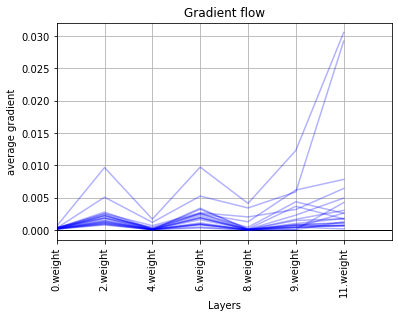

In [231]:
# 填充csv文件路径和学习周期epochs
model, loss_records = batch_training('TrainData.csv', 'TestData.csv', BatchSize=6000, epochs=200)

TrainLoss    0.074106
TestLoss     0.102216
dtype: float64


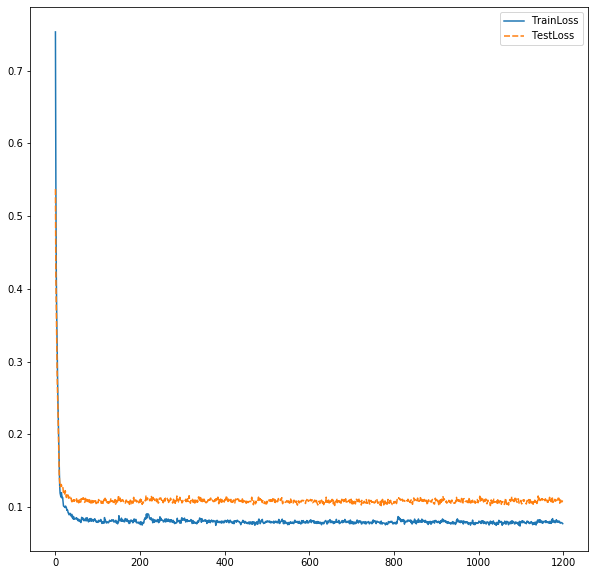

In [232]:
def plot_lossgraph(loss):
    import matplotlib.pyplot as plt
    import seaborn as sb

    print(loss.min())
    f = plt.figure(figsize=(10, 10))
    plt.rcParams['agg.path.chunksize'] = 1000
    sb.lineplot(data=loss)

plot_lossgraph(loss_records)

---

In [233]:
# generate the prediction to pandas.DataFrame 
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt 

test = pd.read_csv('TestData.csv')

prediction = pd.DataFrame()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i in range(3):
    test_batch = test.iloc[6000*i:6000*i+6000]
    y_test = test_batch['consumption']
    X_test = test_batch.drop(['consumption', 'Unnamed: 0'], axis=1)
    X_test = torch.tensor(np.mat(X_test)).float().to(device)
    y_test = torch.tensor(np.mat(y_test)).float().to(device)
    y_pred = model(X_test)
    y_pred = y_pred.cpu()
    y_pred = y_pred.detach().numpy()
    prediction = pd.concat([prediction,pd.DataFrame(y_pred)],axis=0)
    

In [234]:
import pickle 
with open('Scalar.pickle', 'rb') as file:
    Scalar = pickle.load(file)

prediction = Scalar.inverse_transform(prediction)

In [235]:
prediction = pd.Series(prediction.tolist())
prediction = prediction.apply(lambda x: x[0])

In [236]:
origin = pd.read_csv('Original_y0.csv',header=None)
y0 = origin.iloc[96+96-1:-96]
# diff = origin - origin.shift(96)
# diff = diff.iloc[96+96+96-1:-96]
y = origin.iloc[96+96+96-1:]

y0.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
# diff.reset_index(drop=True, inplace=True)
prediction.reset_index(drop=True, inplace=True)

result = pd.concat([y0,prediction,y],axis=1)

In [237]:
result.columns = ['y0','diff','actual']
result['pred'] = result['y0'] + result['diff']
result

,y0,diff,actual,pred
0,698.0,1305.294912,2281.0,2003.294912
1,712.0,1143.447118,2185.0,1855.447118
2,723.0,99.996446,2137.0,822.996446
3,740.0,1050.386773,2067.0,1790.386773
4,746.0,1076.756554,5013.0,1822.756554
5,718.0,1116.891150,5675.0,1834.891150
6,771.0,1269.459388,5734.0,2040.459388
7,688.0,1243.805356,5684.0,1931.805356
8,695.0,1300.451779,5814.0,1995.451779
9,710.0,1340.671838,5717.0,2050.671838


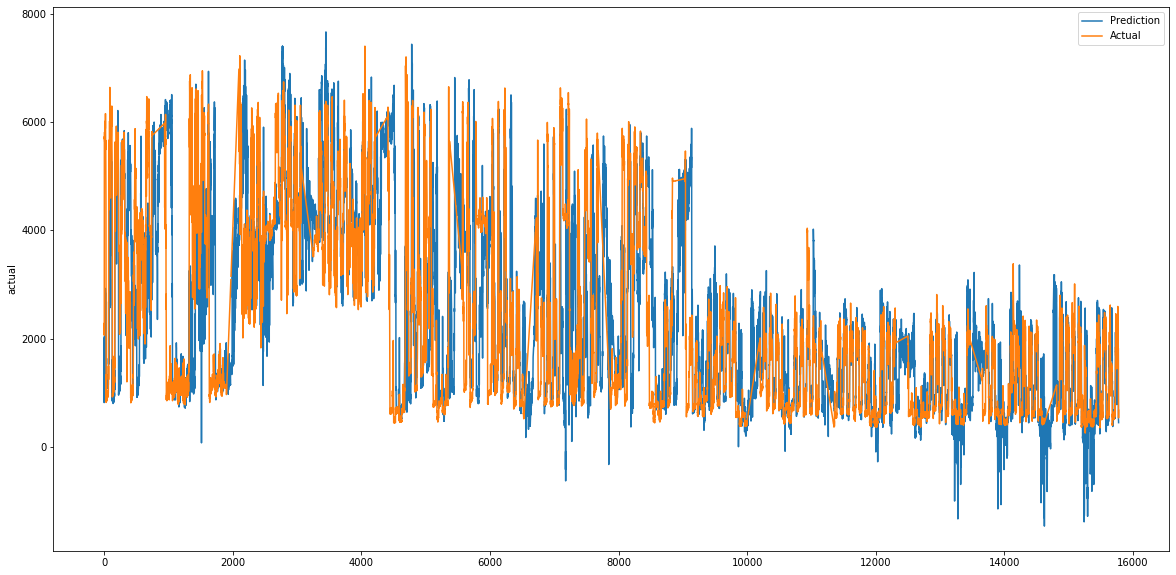

In [238]:
import seaborn as sb
f = plt.figure(figsize=(20,10))
sb.lineplot(x=result.index,y='pred',data=result)
sb.lineplot(x=result.index,y='actual',data=result)

plt.legend(labels=['Prediction', 'Actual'])


In [ ]:
# prediction = pd.Series(prediction.tolist())
# prediction = prediction.apply(lambda x: x[0])
# origin_data = pd.read_csv('consumption_interpolated_updated.csv')
# origin_data = origin_data['consumption'].iloc[48509:]
# diff_1st = origin_data - origin_data.shift(96)
# origin_data = origin_data.iloc[96*2:]
# diff_1st = origin_data.iloc[96:]

# diff_1st.reset_index(drop=True, inplace=True)
# origin_data.reset_index(drop=True, inplace=True)
# result = pd.concat([origin_data,diff_1st,prediction],axis=1,ignore_index=True)
# result

(1, 500)

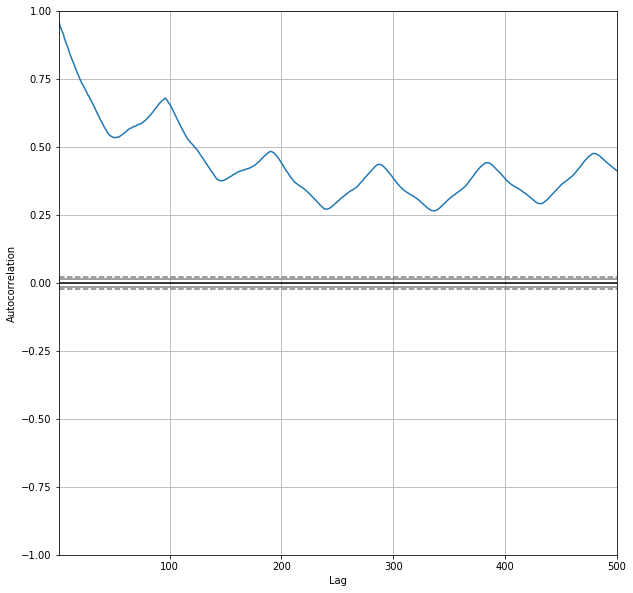

In [239]:
# display auto-correlation graph 
from pandas.plotting import autocorrelation_plot as auto_p
plt.figure(figsize=(10,10))
f = auto_p(result['pred'])
f.set_xlim([1,500])